In [7]:
import json
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import csv
import os
from transformers import AutoTokenizer
import re
import xml.etree.ElementTree as ET
import wikitextparser as wtp
import string
import seaborn as sns
import random
import numpy as np
import math
import pandas as pd
from scipy import integrate, stats
from tqdm import tqdm

In [4]:
ROOT = '/data0/lucy/language-map-of-science/'
DATA = ROOT + 'data/'
LOGS = ROOT + 'logs/'
CLUSTER_FOLDER = LOGS + 'word_clusters_eval/'
INDEX_DIR = '/data0/lucy/language-map-of-science/logs/inverted_index/'

In [18]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

## Wiktionary

`lb` stands for "label". See here: https://en.wiktionary.org/wiki/Template:label
- To label senses with restricted usage
- To label senses with grammatical information, in addition to that in the part-of-speech heading and headword line

`wiktionary_definitions.json` is created by `process_wiktionary.py` and contains all words in our sense vocab file.

In [4]:
with open(DATA + 'validation/wiktionary_definitions.json', 'r') as infile: 
    wiki_defs = json.load(infile)
tokenizer = AutoTokenizer.from_pretrained('globuslabs/ScholarBERT', use_fast=True)
with open(INDEX_DIR + 'SKIP_lemma.json', 'r') as infile: 
    lemma_map = json.load(infile) # {lemma : [tokenizer word IDs]}

In [5]:
rev_lemma_map = {} # { word : lemma }
for lemma in lemma_map: 
    for wordID in lemma_map[lemma]: 
        w = tokenizer.convert_ids_to_tokens(int(wordID)).lower()
        rev_lemma_map[w] = lemma

What kinds of words in our vocabulary are not found in wiktionary? 

We want to make sure we filter out words that don't have clusters (these are words split into wordpieces). 

In [6]:
vocab = set()
missing_vocab_errors = set()
with open(LOGS + 'sense_vocab/wsi_vocab_set_98_50.txt', 'r') as infile: 
    for line in infile: 
        w = line.strip()
        if w not in rev_lemma_map: 
            missing_vocab_errors.add(w)
            continue
        lemma = rev_lemma_map[w] # how to get the clusters for a vocab word
        if not os.path.exists(LOGS + 'word_clusters_lemmed/0.0/' + lemma + '_clustering.json'):
            missing_vocab_errors.add(w)
            continue
        vocab.add(w)
print("Vocab with clusters:", len(vocab))

Vocab with clusters: 6497


In [7]:
# this cell runs without printing anything because all of the words missing above are wordpieces
cands = defaultdict(list)
for w in missing_vocab_errors: 
    cands[w].append(tokenizer.tokenize(w))
    cands[w].append(tokenizer.tokenize(w.upper()))
    cands[w].append(tokenizer.tokenize(w.title()))
for w in cands: 
    for cand in cands[w]: 
        if len(cand) == 1: print(cand)

In [26]:
missing = set()
words_found = 0
for w in vocab: 
    if w not in wiki_defs: 
        missing.add(w)
    else: 
        words_found += 1
print(list(missing)[:50])
print(words_found)

['ireland', 'hi', 'russia', 'saudi', 'fc', 'sf', 'res', 'beijing', 'es', 'european', 'sun', 'bad', 'london', 'british', 'ho', 'act', 'florida', 'nine', 'michael', 'hiv', 'ar', 'switzerland', 'pt', 'seven', 'six', 'finnish', 'men', 'zealand', 'iran', 'bangladesh', 'africa', 'n2', 'ca', 'rc', 'si', 'italian', 'arabia', 'got', 'thomas', 'pi', 'pan', 'chen', 'war', 'denmark', 'na', 'pp', 'cu', 'n', 'doi', 'vii']
6168


What do wiktionary definitions and labels look like? 

In [9]:
num_examples = 0
for w in wiki_defs:
    if w not in vocab: continue
    print(w)
    for defi in wiki_defs[w]: 
        print('\t', defi)
    print()
    num_examples += 1
    if num_examples > 20: break

organism
	 ['Noun', '# {{lb|en|biology}} A discrete and complete [[living]] thing, such as [[animal]], [[plant]], [[fungus]] or [[microorganism]].']
	 ['Noun', '# {{lb|en|by extension}} Any [[complex]] thing with properties normally associated with living things.']

skeleton
	 ['Noun', '# {{lb|en|anatomy}} The [[system]] that provides support to an [[organism]], internal and made up of [[bone]]s and [[cartilage]] in [[vertebrate]]s, external in some other animals.']
	 ['Noun', '# An [[anthropomorphic]] [[representation]] of a skeleton.']
	 ['Noun', '# {{lb|en|figuratively}} A very thin person.']
	 ['Noun', '# {{lb|en|figuratively}} The central core of something that gives shape to the entire structure.']
	 ['Noun', '# {{lb|en|architecture}} A [[frame]] that provides support to a [[building]] or other construction.']
	 ['Noun', '# {{lb|en|computing|middleware}} A client-helper procedure that communicates with a [[stub]].']
	 ['Noun', '# {{lb|en|geometry}} The [[vertex|vertices]] and [[e

In [10]:
whole_labels = Counter()
for w in wiki_defs: 
    if w not in vocab: continue
    for tup in wiki_defs[w]: 
        definition = tup[1]
        if definition.startswith('# {{'): 
            contents = definition.split('}}')
            for item in contents: 
                item = item.replace('# ', '').strip().lower()
                if item.startswith('{{lb|en'): 
                    whole_labels[item] += 1

Labels typically start with `lb` and then `en`, followed by some number of labels separated by `|`. 

In [11]:
whole_labels.most_common()

[('{{lb|en|transitive', 2325),
 ('{{lb|en|obsolete', 1189),
 ('{{lb|en|intransitive', 888),
 ('{{lb|en|uncountable', 472),
 ('{{lb|en|countable', 468),
 ('{{lb|en|computing', 306),
 ('{{lb|en|music', 256),
 ('{{lb|en|mathematics', 252),
 ('{{lb|en|archaic', 250),
 ('{{lb|en|slang', 187),
 ('{{lb|en|informal', 179),
 ('{{lb|en|legal', 176),
 ('{{lb|en|transitive|obsolete', 169),
 ('{{lb|en|medicine', 157),
 ('{{lb|en|dated', 152),
 ('{{lb|en|nautical', 150),
 ('{{lb|en|grammar', 136),
 ('{{lb|en|physics', 131),
 ('{{lb|en|chemistry', 119),
 ('{{lb|en|figuratively', 116),
 ('{{lb|en|ambitransitive', 109),
 ('{{lb|en|colloquial', 103),
 ('{{lb|en|figurative', 99),
 ('{{lb|en|biology', 95),
 ('{{lb|en|finance', 93),
 ('{{lb|en|sports', 93),
 ('{{lb|en|geometry', 92),
 ('{{lb|en|military', 90),
 ('{{lb|en|linguistics', 85),
 ('{{lb|en|obsolete|transitive', 73),
 ('{{lb|en|historical', 73),
 ('{{lb|en|intransitive|obsolete', 71),
 ('{{lb|en|programming', 70),
 ('{{lb|en|cricket', 68),
 ('{{l

In [12]:
def get_label_list(tup):
    definition = tup[1]
    if definition.startswith('# {{'): 
        contents = definition.split('}}')
        label_list = set()
        for item in contents: 
            item = item.replace('# ', '').strip().lower()
            if item.startswith('{{lb|en'): 
                label_list.update(item.split('|')[2:])
        return label_list
    return set()

labels = Counter()
for w in wiki_defs: 
    if w not in vocab: continue
    for tup in wiki_defs[w]: 
        label_list = get_label_list(tup)
        if '' in label_list: 
            print(tup[1]) # see why some are empty strings
        labels.update(label_list)

# {{lb|en|Ireland||North America|slang}} [[comical|Comical]], [[zany]]; [[fun]], [[amusing]].
# {{lb|en||usually|not comparable}} No longer [[living]]. {{q|Also used as a noun.}}
# {{lb|en||usually|not comparable}} Devoid of life.
# {{lb|en|US|now|dated|}} Of skin color other than white; in particular, [[black]].
# {{lb|en||calculus}} A [[differential]] [[operator]] that maps each point of a [[scalar field]] to a [[vector]] pointed in the direction of the greatest rate of change of the scalar. Notation for a scalar field φ: &nabla;&phi;
# {{lb|en||obsolete|or|dialect}} [[maybe]], [[perhaps]].
# {{lb|en|AU|}} A [[thunderstorm]].
# {{lb|en||of a hand}} Preferred and used with greater [[dexterity]] than the other, as the right hand of a [[right-handed]] person or the left hand of a [[left-handed]] one.
# {{lb|en|archaeology|mainly||US}} A cultural sub-period or level within a more encompassing time period.
# {{lb|en|transitive|}} To place in or under by a mental or rational process; to as

In [13]:
labels.most_common()

[('transitive', 3665),
 ('obsolete', 1847),
 ('intransitive', 1574),
 ('countable', 886),
 ('uncountable', 874),
 ('slang', 698),
 ('computing', 537),
 ('archaic', 490),
 ('informal', 447),
 ('mathematics', 408),
 ('dated', 391),
 ('us', 357),
 ('colloquial', 321),
 ('music', 309),
 ('_', 298),
 ('legal', 287),
 ('uk', 271),
 ('rare', 262),
 ('medicine', 252),
 ('nautical', 225),
 ('chiefly', 211),
 ('now', 199),
 ('physics', 196),
 ('in the plural', 194),
 ('figuratively', 188),
 ('figurative', 185),
 ('historical', 178),
 ('chemistry', 170),
 ('grammar', 170),
 ('military', 167),
 ('sports', 162),
 ('finance', 149),
 ('ambitransitive', 140),
 ('linguistics', 139),
 ('biology', 135),
 ('by extension', 130),
 ('or', 126),
 ('programming', 126),
 ('dialectal', 122),
 ('scotland', 117),
 ('british', 115),
 ('geometry', 112),
 ('cricket', 105),
 ('not comparable', 98),
 ('law', 97),
 ('baseball', 96),
 ('usually', 95),
 ('logic', 90),
 ('internet', 90),
 ('botany', 89),
 ('australia', 77)

In [14]:
labels['by extension']

130

### Compare Wiktionary labels to MAG fields of study

MAG fields of study are at different levels in a hierarchy.

In [27]:
level_to_topics = defaultdict(set)
with open(DATA + 'fos_level.csv', 'r') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader: 
        level_to_topics[row['level']].add(row['displayname'].lower())

In [28]:
child_to_parent = defaultdict(set)
with open(DATA + 'mag_parent_child.csv', 'r') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader: 
        if row['parent_display_name'].lower() in level_to_topics['0']: 
            if row['child_display_name'].lower() in level_to_topics['1']: 
                child_to_parent[row['child_display_name'].lower()].add(row['parent_display_name'].lower())

In [29]:
# categories that exist that adjacent levels
# there is no overlap between level 0 and 1
level_list = sorted(level_to_topics.keys())
for i, level1 in enumerate(level_list): 
    if i == len(level_list)-1: break
    level2 = level_list[i+1]
    print(level1, level2, level_to_topics[level1] & level_to_topics[level2])

0 1 set()
1 2 {'control theory'}
2 3 {'correlation and dependence', 'conjoint analysis', 'record locking', 'metre', 'lexical analysis', 'accretion (meteorology)', 'educational technology', 'degeneration theory', 'psyllium', 'sensory processing'}
3 4 {'perilla', 'pyrantel', 'yield spread', 'human mating strategies'}
4 5 set()


In [30]:
labels_set = set(labels.keys())
for level in sorted(level_to_topics.keys()): 
    print('LEVEL', level)
    print('\t', 'NUMBER OF MAG TOPICS:', len(level_to_topics[level]))
    overlap = labels_set & level_to_topics[level]
    print('\t', 'OVERLAP W/ WIKTIONARY:', len(overlap))
    print('\t', 'EXAMPLES:', list(overlap)[:20])
    print()

LEVEL 0
	 NUMBER OF MAG TOPICS: 19
	 OVERLAP W/ WIKTIONARY: 18
	 EXAMPLES: ['economics', 'philosophy', 'business', 'engineering', 'computer science', 'medicine', 'physics', 'materials science', 'sociology', 'geography', 'mathematics', 'psychology', 'political science', 'biology', 'art', 'geology', 'history', 'chemistry']

LEVEL 1
	 NUMBER OF MAG TOPICS: 292
	 OVERLAP W/ WIKTIONARY: 96
	 EXAMPLES: ['astronomy', 'electrical engineering', 'obstetrics', 'computer security', 'machine learning', 'biochemistry', 'microbiology', 'archaeology', 'software engineering', 'earth science', 'forestry', 'criminology', 'mechanical engineering', 'commerce', 'algebra', 'physiology', 'organic chemistry', 'veterinary medicine', 'horticulture', 'climatology']

LEVEL 2
	 NUMBER OF MAG TOPICS: 137362
	 OVERLAP W/ WIKTIONARY: 252
	 EXAMPLES: ['probability theory', 'storm', 'publishing', 'aerospace', 'location', 'law enforcement', 'commutative algebra', 'alchemy', 'bookbinding', 'fetishism', 'semiotics', 'fando

In [32]:
def calculate_wiktionary_coverage(levels_to_keep, wik_cats_to_ignore=set(), print_multi=False):
    '''
    Depending on which levels to keep, we might get diminishing returns as we go into
    more fine-grained MAG topics. This function calculates the following: 
    - how many domain-specific senses we have 
    - how many (and what percent of) vocab words have at least one domain-specific sense
    - what wiktionary domains are common/prolific across words
    '''
    print(levels_to_keep)
    words_with_topic = defaultdict(set) # {word : [topic in mag]}
    domain_specific_senses = [] # [(word, domain)]
    covered_word = [] # list of words with at least one domain-specific sense
    domain_count = Counter() 
    for w in wiki_defs: 
        if w not in vocab: continue
        all_overlap = set()
        all_levels = set()
        for tup in wiki_defs[w]: 
            label_list = get_label_list(tup)
            if not label_list: continue
            for level in levels_to_keep: 
                topics = level_to_topics[level]
                overlap = label_list & topics
                overlap = overlap - wik_cats_to_ignore
                for domain in overlap: 
                    domain_specific_senses.append((w, domain))
                    if level == levels_to_keep[-1]:
                        domain_count[domain] += 1
                if len(overlap) > 0: 
                    covered_word.append(w)
                    all_levels.add(level)
                all_overlap.update(overlap)
        if print_multi and len(all_levels) > 1: 
            print(w, "has multi-level labels", all_overlap)
    print("# of domain-specific senses:", len(domain_specific_senses))
    print("# or % of words with labeled senses:", len(covered_word), round(len(covered_word)*100 / len(vocab), 2))
    print("popular domains", domain_count.most_common(10))
    print()

In [33]:
wik_cats_to_ignore = set(['slang'])

levels_to_keep = ['0']
calculate_wiktionary_coverage(levels_to_keep, wik_cats_to_ignore)

levels_to_keep = ['0', '1']
calculate_wiktionary_coverage(levels_to_keep, wik_cats_to_ignore)

levels_to_keep = ['0', '1', '2']
calculate_wiktionary_coverage(levels_to_keep, wik_cats_to_ignore)

levels_to_keep = ['0', '1', '2', '3']
calculate_wiktionary_coverage(levels_to_keep, wik_cats_to_ignore)

levels_to_keep = ['0', '1', '2', '3', '4']
calculate_wiktionary_coverage(levels_to_keep, wik_cats_to_ignore)

levels_to_keep = ['0', '1', '2', '3', '4', '5']
calculate_wiktionary_coverage(levels_to_keep, wik_cats_to_ignore)

['0']
# of domain-specific senses: 1583
# or % of words with labeled senses: 1530 23.55
popular domains [('mathematics', 408), ('medicine', 252), ('physics', 196), ('chemistry', 170), ('biology', 135), ('engineering', 74), ('geology', 70), ('economics', 56), ('business', 55), ('philosophy', 49)]

['0', '1']
# of domain-specific senses: 3039
# or % of words with labeled senses: 2963 45.61
popular domains [('finance', 149), ('linguistics', 139), ('geometry', 112), ('law', 97), ('botany', 89), ('statistics', 68), ('astronomy', 59), ('anatomy', 58), ('genetics', 55), ('algebra', 46)]

['0', '1', '2']
# of domain-specific senses: 4808
# or % of words with labeled senses: 4695 72.26
popular domains [('grammar', 170), ('cricket', 105), ('architecture', 70), ('aviation', 69), ('electronics', 60), ('politics', 55), ('christianity', 46), ('phonetics', 44), ('photography', 36), ('typography', 34)]

['0', '1', '2', '3']
# of domain-specific senses: 5356
# or % of words with labeled senses: 5241 80

We decided to keep only level 0 and level 1, since these are manually defined (but abstracts are still semi-automatically tagged), and filter based on how many abstracts fall under each category later. 

We also *filter out words* where all definitions fall under a single domain (or one domain and "by extension") e.g. "immunostaining", "neoplasm", "pharmacokinetic", and "cirrhosis" 

We allow level 1 FOS to inherit the domain-specific words of their level 0 parent. 

In [34]:
def single_domain(definitions, topics_to_keep): 
    '''
    Return true if a definition is in a distinct domain, otherwise
    return false 
    '''
    domain_count = Counter()
    for tup in definitions: 
        label_list = get_label_list(tup)
        overlap = label_list & topics_to_keep
        overlap = overlap - wik_cats_to_ignore
        for domain in overlap: 
            domain_count[domain] += 1
    for domain in domain_count: 
        # every definition is marked with the same domain
        if domain_count[domain] == len(definitions): 
            return True
    return False
        
levels_to_keep = ['0', '1']
topics_to_keep = set()
for level in levels_to_keep: 
    topics_to_keep.update(level_to_topics[level])
label_to_words_all = defaultdict(set) # {label: [words in with that label]}
for w in wiki_defs: 
    if w not in vocab: continue
    if len(wiki_defs[w]) == 1: continue
    if single_domain(wiki_defs[w], topics_to_keep): continue
    for tup in wiki_defs[w]: 
        label_list = get_label_list(tup)
        if not label_list: continue
        overlap = label_list & topics_to_keep
        overlap = overlap - wik_cats_to_ignore
        for domain in overlap: 
            label_to_words_all[domain].add(w)

In [35]:
print(label_to_words_all['botany'])

{'disc', 'social', 'heart', 'acute', 'foot', 'cell', 'entire', 'key', 'continuous', 'stimulus', 'radical', 'disk', 'test', 'ray', 'grain', 'terrestrial', 'attached', 'column', 'stone', 'perfect', 'suspended', 'axial', 'self', 'single', 'emergent', 'rupture', 'sport', 'patent', 'leaf', 'regular', 'series', 'reverse', 'inverse', 'stem', 'axis', 'abrupt', 'incomplete', 'strict', 'attenuated', 'coherent', 'shell', 'cycle', 'node', 'alternate', 'set', 'aggregate', 'seed', 'median', 'culture', 'attenuation', 'volunteer', 'imperfect', 'plant', 'radial', 'opposite', 'partial', 'running', 'habit', 'offset', 'replicate', 'composite', 'standard', 'neck', 'inserted', 'base', 'stick', 'string', 'persistent', 'section', 'reversed', 'hair', 'fruit', 'kernel', 'linear', 'annual', 'cyclic', 'wall'}


In [36]:
label_to_words = defaultdict(set)
for label in label_to_words_all: 
    if label in child_to_parent and label in level_to_topics['1']: 
        # inherit parents
        for parent in child_to_parent[label]: 
            label_to_words[label].update(label_to_words_all[parent])
        # add itself
        label_to_words[label].update(label_to_words_all[label])

In [42]:
list_label_to_words = defaultdict(list)
for label in label_to_words: 
    list_label_to_words[label] = list(label_to_words[label])
with open(LOGS + 'wiktionary/label_to_words.json', 'w') as outfile: 
    json.dump(list_label_to_words, outfile)

### Get total number of examples

We have already filtered down to words that have clusters. 

The printout cell below prints out the number of abstracts in each FOS and the number of domain-specific senses. 

In [44]:
fos_papers = defaultdict(list) # { level 0 or 1 fos : [mag paper IDs]}
with open(LOGS + 'wiktionary/s2orc_fos.json', 'r') as infile:
    s2orc_fos = json.load(infile) # {s2orc ID : [MAG FOS]}
for s2orc_ID in tqdm(s2orc_fos): 
    for fos in s2orc_fos[s2orc_ID]: 
        fos_papers[fos].append(s2orc_ID)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 11990654/11990654 [00:08<00:00, 1413871.69it/s]


In [45]:
random.seed(0)
fos_count = Counter() # {field of study : number of abstracts}
for fos in fos_papers: 
    if fos in label_to_words: 
        fos_count[fos] = len(fos_papers[fos])
total_examples = 0
for tup in fos_count.most_common(): 
    fos, count = tup
    domain_specific_senses = len(label_to_words[fos])
    if len(label_to_words[fos]) > 10: 
        examples = random.sample(list(label_to_words[fos]), 10)
    else: 
        examples = label_to_words[fos]
    total_examples += domain_specific_senses
    print(fos, '\t', str(count), '\t', str(domain_specific_senses))
    print('\t', ', '.join(examples))

aesthetics 	 50000 	 60
	 transient, reduction, abstraction, phenomenon, mechanistic, subject, appearance, ethics, demonstration, absolute
literature 	 50000 	 19
	 accessible, catalyst, pointing, underground, tone, procedural, passage, abstraction, transparency, saturation
management 	 50000 	 52
	 demand, conservative, capital, producer, growth, nominal, risk, service, consumer, manager
psychoanalysis 	 50000 	 41
	 flow, coping, multiplicity, disturbance, agency, complex, project, suppression, extinction, mask
archaeology 	 50000 	 34
	 culture, basin, handle, thematic, depression, locality, profile, horizon, zone, ancient
civil engineering 	 50000 	 67
	 fitting, lift, trace, loss, principal, attenuation, root, strain, baseline, cure
communication 	 50000 	 59
	 suppression, resilience, channel, gender, deviate, inversion, achievement, behavior, stratification, reinforcement
advertising 	 50000 	 63
	 firm, motivation, lead, diversity, line, move, absorb, leverage, spread, capital


In [46]:
# note that this is before checking which of these words actually have NPMI scores 
print("Total number of validation examples:", total_examples)
print("Total number of domains:", len(fos_count))

Total number of validation examples: 12732
Total number of domains: 83


# Wiktionary recall

Models: 
- (baseline) type NPMI (these are whole-word lemmas)
- sense NPMI (these are the shortest word form of a lemma in ScholarBERT's vocabulary) 

Evaluation vocabulary: 
- every sense lemma that occurs often enough to have a type NPMI score 
- this is a smaller number than what is reported above (since some wiktionary words do not appear often enough in their FOS in our dataset)

In [8]:
def get_wiktionary_candidates(inpath_prefix): 
    resolution_vals = [0.0, 0.5, 1.0, 1.5, 2.0, 2.5]
    most_npmi_list = []
    max_npmi_list = []
    for resolution in resolution_vals: 
        with open(inpath_prefix + str(resolution) + '_most_fos_sense_npmi.json', 'r') as infile: 
            most_npmi_list.append(json.load(infile))
        with open(inpath_prefix + str(resolution) + '_max_fos_sense_npmi.json', 'r') as infile: 
            max_npmi_list.append(json.load(infile))

    type_folder = LOGS + 'type_npmi/fos_set-False_lemma-True/'
    type_npmi = defaultdict(Counter) # {fos : { word : npmi }}
    for f in tqdm(os.listdir(type_folder)):
        with open(type_folder + f, 'r') as infile: 
            reader = csv.DictReader(infile)
            for row in reader: 
                type_npmi[f][row['word']] = float(row['pmi'])
                
    return most_npmi_list, max_npmi_list, type_npmi

def get_evaluation_vocab(max_npmi_list): 
    '''
    Denominator of recall: all lemmas that have NPMI scores and wiktionary entries
    '''
    resolution_vals = [0.0, 0.5, 1.0, 1.5, 2.0, 2.5]
    for i, max_npmi in enumerate(max_npmi_list): 
        eval_vocab = defaultdict(set)
        total_eval_vocab = 0
        for group in max_npmi: 
            v = label_to_words[group] & set(max_npmi[group]) & set(type_npmi[group])
            eval_vocab[group] = v
            total_eval_vocab += len(v)
        print(resolution_vals[i], "TOTAL", '\t', total_eval_vocab)
    return eval_vocab

def check_eval_vocab_consistency(max_npmi_list, type_npmi): 
    max_npmi1 = max_npmi_list[-1]
    max_npmi2 = max_npmi_list[-2]
    for group in max_npmi:
        v1 = label_to_words[group] & set(max_npmi1[group]) & set(type_npmi[group])
        v2 = label_to_words[group] & set(max_npmi2[group]) & set(type_npmi[group])
        print(group, v2 - v1)

In [20]:
def make_recall_curve(npmi_dict, exp_name, eval_vocab): 
    '''
    This calculates recall for each threshold for each FOS (so we can have
    confidence intervals over FOS)
    macro: unweighted mean of per-FOS recall 
    micro: sum of true positives for all the classes divided by the all positive predictions
    weighted: weighted mean of per-FOS recall, weighted by # of words that can be recalled per FOS
    '''
    d = {
        'threshold': [], 
        'recall_type' : [],
        'recall': [],
        'exp_name' : [],
    }
    thresholds = np.array(list(range(0, 101))) / 100
    recall_order = ['macro avg recall', 'micro avg recall']
    recall = [np.zeros(len(thresholds)), np.zeros(len(thresholds))]
    per_group_recall = []
    group_size = []
    total_wiktionary_terms = 0
    total_possible_in_npmi_dict = 0 
    for group in npmi_dict: 
        bucket = defaultdict(set) # rounded to the nearest 
        wiktionary_terms = eval_vocab[group]
        if len(wiktionary_terms) == 0: continue
        total_wiktionary_terms += len(wiktionary_terms)
        for w in npmi_dict[group]: 
            if w not in wiktionary_terms: continue
            npmi = float(npmi_dict[group][w])
            bucket_key = math.floor(npmi*100)/100
            bucket[bucket_key].add(w)
            total_possible_in_npmi_dict += 1
        group_recall = np.zeros(len(thresholds))
        for i, bucket_key in enumerate(thresholds): 
            # add to all group's recall array
            recall[1][i] += len(bucket[bucket_key])
            # append to this group's recall array
            group_recall[i] = len(bucket[bucket_key])
        group_recall = np.cumsum(group_recall[::-1])[::-1] / len(wiktionary_terms)
        per_group_recall.append(group_recall)
        group_size.append(len(wiktionary_terms))
    print("TOTAL TERMS:", total_wiktionary_terms)
    print("TOTAL TERMS IN NPMI DICT AND WIKTIONARY:", total_possible_in_npmi_dict)
    per_group_recall = np.array(per_group_recall)
    recall[0] = np.sum(per_group_recall, axis=0) / len(per_group_recall) # macro recall 
    print("TOTAL EXAMPLES RECALLED:", np.cumsum(recall[1][::-1])[::-1][0])
    recall[1] = np.cumsum(recall[1][::-1])[::-1] / total_wiktionary_terms # micro recall
    for i, recall_type in enumerate(recall_order): 
        area_under_curve = integrate.trapezoid(recall[i], x=thresholds)
        print(exp_name.upper(), recall_type, "AREA UNDER CURVE:", round(area_under_curve, 4))
        for j, val in enumerate(recall[i]): 
            d['threshold'].append(thresholds[j])
            d['recall'].append(recall[i][j])
            d['recall_type'].append(recall_type)
            d['exp_name'].append(exp_name)
    print()
    df = pd.DataFrame(data=d)
    return df

In [144]:
#most_df = make_recall_curve(most_npmi, 'most WSIatScale')
def plot_against_type_baseline(wsi_npmi_list, label_prefix, eval_vocab): 
    resolution_vals = [0.0, 0.5, 1.0, 1.5, 2.0, 2.5]
    type_df = make_recall_curve(type_npmi, 'type NPMI', eval_vocab)
    exp_list = [type_df]
    for i, wsi_npmi in enumerate(wsi_npmi_list): 
        resolution = resolution_vals[i]
        if resolution not in set([0.0, 1.0]): continue # only plot a few lines
        if resolution == 0: 
            label = "sense NPMI, dynamic $\gamma$"
        else: 
            label = "sense NPMI, $\gamma$ = " + str(resolution)
        wsi_df = make_recall_curve(wsi_npmi, label, eval_vocab)
        exp_list.append(wsi_df)
    all_exp_df = pd.concat(exp_list, ignore_index=True)
    recall_order = ['macro avg recall', 'micro avg recall']
    line_styles = ['-', ':', '--', '-.']
    for i, recall_type in enumerate(recall_order): 
        if 'macro' in recall_type: continue
        plt.rcParams["figure.figsize"] = (5, 3)
        fig, axes = plt.subplots(1, 1, sharey=True)
        recall_df = all_exp_df[all_exp_df['recall_type'] == recall_type]
        sns.lineplot(x="threshold", y="recall", hue='exp_name', data=recall_df, 
                     alpha=0.5, style='exp_name') #, ax=axes[i])
        axes.legend(fontsize=20, bbox_to_anchor=(1.05, -0.3))
        if 'macro' in recall_type: 
            axes.set_title('Recall, macro-averaged over each subfield', fontsize=20)
        axes.set_xlim(0, 0.5)
        axes.set_xlabel("NPMI score threshold", fontsize=20)
        axes.set_ylabel("Recall", fontsize=20)
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        plt.show()

In [32]:
def compare_target_fos_to_random(wsi_npmi_list, label_prefix, title): 
    resolution_vals = [0.0, 0.5, 1.0, 1.5, 2.0, 2.5]
    d = {
        "exp name": [], 
        "FOS": [], 
        "NPMI": []
    }
    for i, wsi_npmi_dict in enumerate(wsi_npmi_list): 
        resolution = resolution_vals[i]
        exp_name = label_prefix + str(resolution)
        if resolution == 0: 
            exp_name = label_prefix + "optimal"
        word2FOS_score = defaultdict(Counter) # {word : {FOS : max NPMI }}
        for FOS in wsi_npmi_dict: 
            for w in wsi_npmi_dict[FOS]: 
                word2FOS_score[w][FOS] = wsi_npmi_dict[FOS][w]
        word_to_labels = defaultdict(list) # {word : [FOS]}
        for label in label_to_words: 
            for w in label_to_words[label]: 
                word_to_labels[w].append(label)
        for w in word_to_labels: 
            all_FOS_w = word2FOS_score[w]
            possible_FOS = word_to_labels[w]
            other_FOS = []
            this_FOS = []
            for FOS in all_FOS_w: 
                if FOS in possible_FOS: 
                    this_FOS.append(FOS)
                else: 
                    other_FOS.append(FOS)
            if len(this_FOS) == 0 or len(other_FOS) == 0: continue
            if len(this_FOS) > len(other_FOS): 
                other_FOS_sample = other_FOS
                this_FOS = random.sample(this_FOS, len(other_FOS))
            else: 
                other_FOS_sample = random.sample(other_FOS, len(this_FOS))
            for FOS in this_FOS: 
                d["exp name"].append(exp_name)
                d["FOS"].append("Wiktionary")
                d["NPMI"].append(all_FOS_w[FOS])
            for FOS in other_FOS_sample: 
                d["exp name"].append(exp_name)
                d["FOS"].append("Random")
                d["NPMI"].append(all_FOS_w[FOS])
    d = pd.DataFrame(data=d)
    exp_of_interest = d[d['exp name'] == label_prefix + 'optimal']
    wiki_vals = exp_of_interest[exp_of_interest['FOS'] == 'Wiktionary']['NPMI'].to_list()
    random_vals = exp_of_interest[exp_of_interest['FOS'] == 'Random']['NPMI'].to_list()
    print("t-test:", stats.ttest_rel(wiki_vals, random_vals, alternative='greater'))
    plt.rcParams["figure.figsize"] = (10, 5)
    fig = sns.kdeplot(data=exp_of_interest, x="NPMI", hue="FOS", shade=True)
    plt.xlabel(title, fontsize=20)
    plt.ylabel("Density", fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    # for legend text
    plt.setp(fig.get_legend().get_texts(), fontsize='20') 
    plt.setp(fig.get_legend().get_title(), fontsize='20') 
    plt.tight_layout()
    plt.show()

In [12]:
most_npmi_list, max_npmi_list, type_npmi = get_wiktionary_candidates(LOGS + 'wiktionary_cands_es/res-')

100%|██████████| 264/264 [00:10<00:00, 26.36it/s]


In [16]:
with open(LOGS + 'wiktionary/label_to_words.json', 'r') as infile: 
    label_to_words = json.load(infile)
for fos in label_to_words: 
    label_to_words[fos] = set(label_to_words[fos])

0.0 TOTAL 	 11548
0.5 TOTAL 	 11548
1.0 TOTAL 	 11548
1.5 TOTAL 	 11548
2.0 TOTAL 	 11548
2.5 TOTAL 	 11548
TOTAL TERMS: 11548
TOTAL TERMS IN NPMI DICT AND WIKTIONARY: 11548
TOTAL EXAMPLES RECALLED: 6346.0
TYPE NPMI macro avg recall AREA UNDER CURVE: 0.0413
TYPE NPMI micro avg recall AREA UNDER CURVE: 0.0434

TOTAL TERMS: 11548
TOTAL TERMS IN NPMI DICT AND WIKTIONARY: 11548
TOTAL EXAMPLES RECALLED: 8167.0
SENSE NPMI, DYNAMIC $\GAMMA$ macro avg recall AREA UNDER CURVE: 0.0642
SENSE NPMI, DYNAMIC $\GAMMA$ micro avg recall AREA UNDER CURVE: 0.0675

TOTAL TERMS: 11548
TOTAL TERMS IN NPMI DICT AND WIKTIONARY: 11548
TOTAL EXAMPLES RECALLED: 7428.0
SENSE NPMI, $\GAMMA$ = 1.0 macro avg recall AREA UNDER CURVE: 0.0552
SENSE NPMI, $\GAMMA$ = 1.0 micro avg recall AREA UNDER CURVE: 0.0583



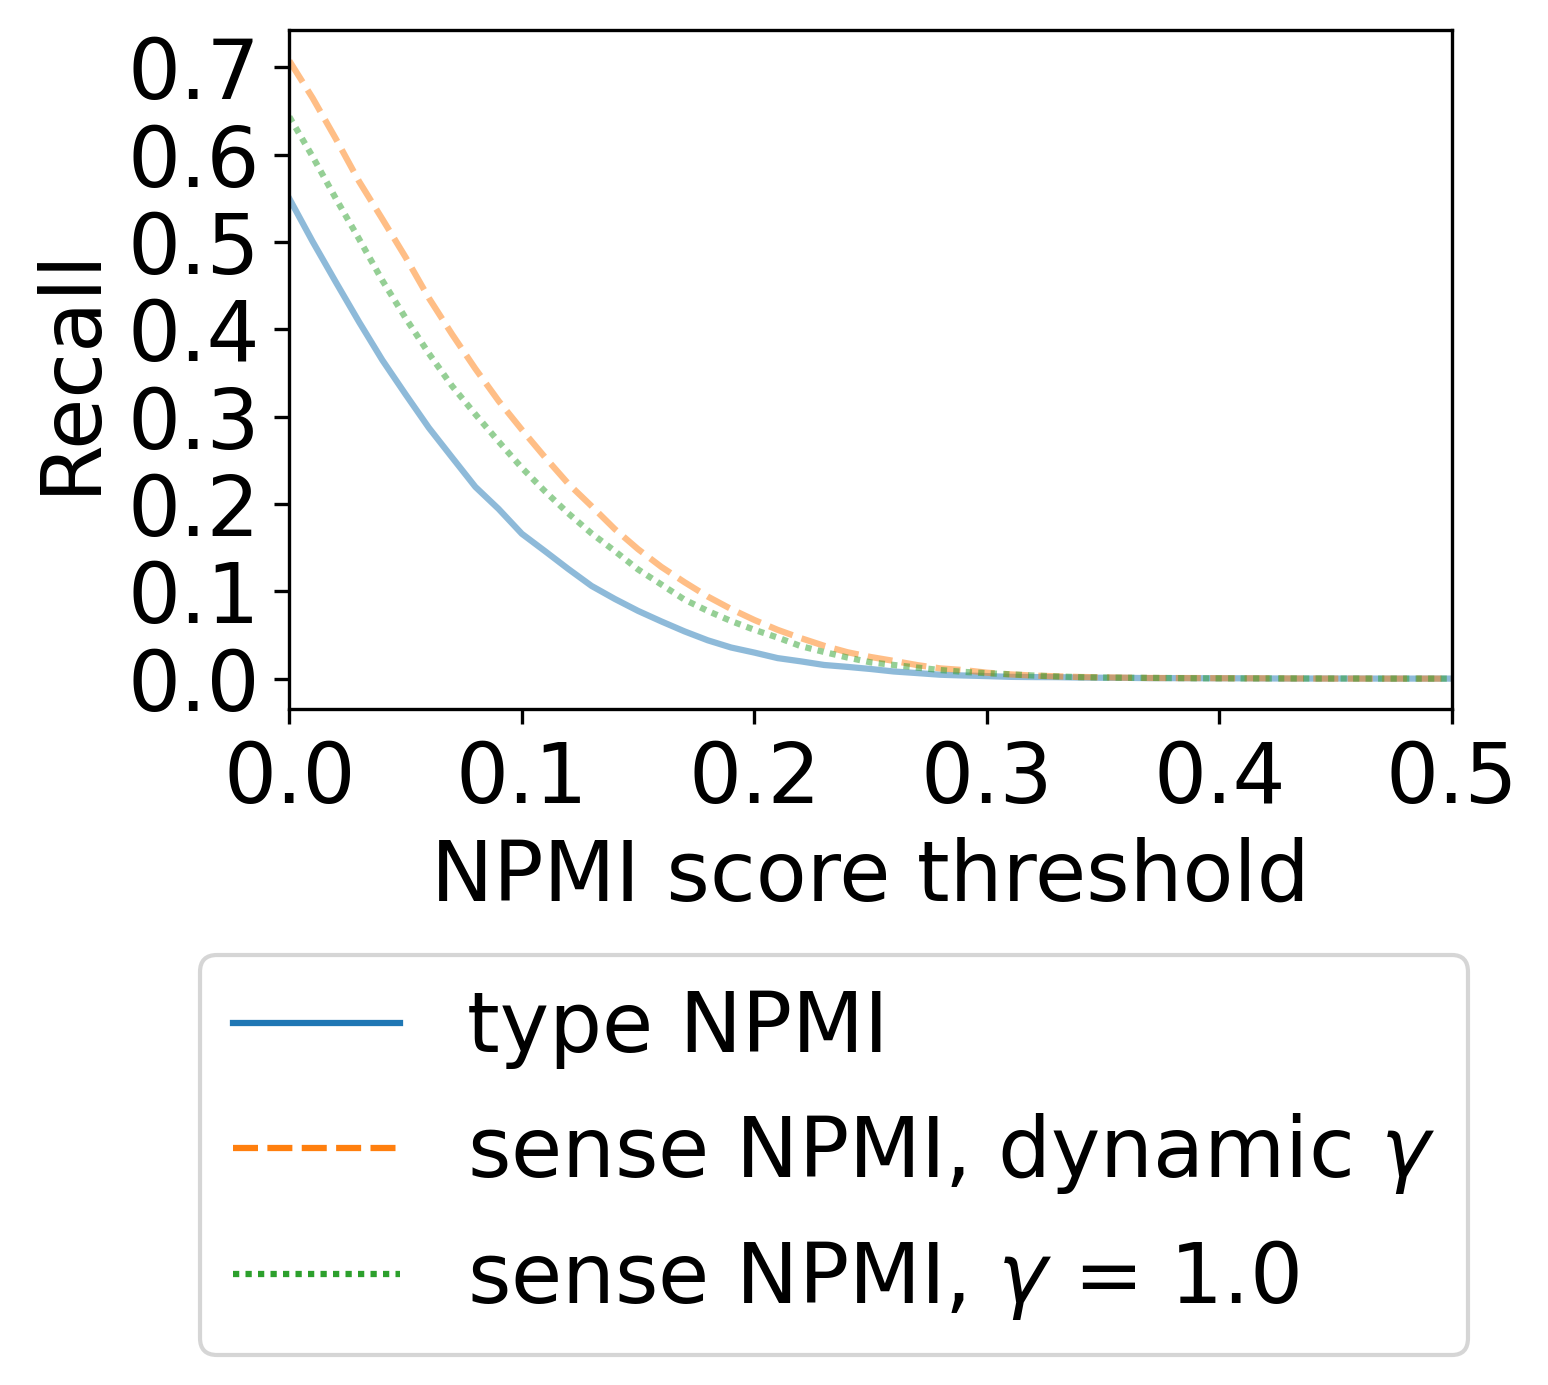

In [145]:
eval_vocab = get_evaluation_vocab(most_npmi_list)
plot_against_type_baseline(most_npmi_list, 'most WSIatScale ', eval_vocab)

### Most common NPMI vs. max NPMI 

In [145]:
def show_top_reps(w, sense, res): 
    '''
    Shows the top reps for a word. 
    If sense is not None, it only prints out the representatives for that sense. 
    n is the number of reps to show. 
    '''
    f = w + '_clustering.json'
    inpath = os.path.join(CLUSTER_FOLDER, str(res), f)
    if not os.path.exists(inpath):
        print(w, 'NOT FOUND')
        return
    with open(inpath, 'r') as infile: 
        d = json.load(infile)[str(NUM_REPS)]
    # this is already sorted by most to least common representatives
    if int(sense) > len(d) - 1: 
        print("\tJaccard similarity = 0 with training examples")
        return
    clust = d[int(sense)]
    rep_str = []
    for rep in clust: 
        rep_str.append(tokenizer.convert_ids_to_tokens(rep[0]))
    print('\t', rep_str[:5])

In [141]:
def show_most_max_disagreements(group, res): 
    in_folder = LOGS + 'fos_senses/res-' + str(res) + '_set-True/'
    sense_counts = defaultdict(Counter) # { word : { sense : count } } 
    sense_npmi = defaultdict(Counter) # { word : { sense : npmi } } 
    with open(in_folder + group, 'r') as infile: 
        reader = csv.DictReader(infile) 
        for row in reader: 
            parts = row['word_sense'].split('_')
            w = parts[0]
            sense = parts[1]
            sense_counts[w][sense] = int(row['count'])
            sense_npmi[w][sense] = float(row['npmi'])

    for w in sense_counts: 
        tup = sense_counts[w].most_common(1)[0]
        sense_ID_most = tup[0]
        most_npmi = sense_npmi[w][tup[0]]

        tup = sense_npmi[w].most_common(1)[0]
        sense_ID_max = tup[0]
        max_npmi = tup[1]

        if sense_ID_max != sense_ID_most: 
            print(w)
            print('MAX', sense_ID_max, max_npmi, sense_counts[w][sense_ID_max])
            show_top_reps(w, sense_ID_max, res)
            print('MOST', sense_ID_most, most_npmi, sense_counts[w][sense_ID_most])
            show_top_reps(w, sense_ID_most, res)
            print()

In [146]:
show_most_max_disagreements('geometry', 1.5)

section
MAX 2 0.15373963441845392 303
	 ['sectional', 'current', 'distribution', 'head', 'cross']
MOST 0 0.01618329607000432 440
	 ['part', 'portion', 'group', 'area', 'subsection']

orientation
MAX 8 0.07867181779091034 162
	 ['asymmetry', 'inclination', 'tilt', 'rotation', 'reorientation']
MOST 0 0.04516362268336388 1728
	 ['alignment', 'order', 'arrangement', 'organization', 'anchor']

regime
MAX 2 0.09601780873653609 45
	 ['behaviour', 'rule', 'feature', 'trend', 'mechanism']
MOST 1 0.07990266548865796 112
	 ['range', 'region', 'limit', 'band', 'state']

center
MAX 5 0.2256299838800426 530
	 ['central', 'core', 'middle', 'end', 'mean']
MOST 1 0.08130371161783814 621
	 ['centre', 'site', 'location', 'system', 'component']

transformation
MAX 3 0.17030487143191433 115
	 ['change', 'variation', 'distortion', 'deformation', 'alteration']
MOST 0 -0.001504774601005293 185
	 ['transform', 'conversion', 'transition', 'reduction', 'metamorphosis']

relative
MAX 1 0.03485770093329784 577
	 [

	 ['trend', 'data', 'table', 'course', 'variation']
MOST 4 0.008610838945876883 240
	 ['number', 'variety', 'host', 'panel', 'lot']

elimination
MAX 4 0.10515807304911681 4
	 ['deletion', 'omission', 'pruning', 'attrition', 'selection']
MOST 0 0.059859685580104474 14
	 ['removal', 'eliminate', 'avoidance', 'prevention', 'reduction']

defect
MAX 4 0.1700740080310779 42
	 ['imperfections', 'fault', 'charge', 'donor', 'density']
MOST 0 -0.04000027963409306 94
	 ['deficiency', 'deficit', 'dysfunction', 'impairment', 'difference']

bilateral
MAX 4 0.08163588404586133 5
	 ['two', 'female', 'individual', 'consecutive', 'multilateral']
MOST 0 0.038283488904194383 59
	 ['contralateral', 'ipsilateral', 'hemispheric', 'synaptic', 'involve']

identical
MAX 1 0.10482322272918174 42
	 ['dissimilar', 'different', 'consecutive', 'two', 'one']
MOST 0 0.005268940485965917 157
	 ['equal', 'equivalent', 'analogous', 'opposite', 'parallel']

region
MAX 4 0.09802250057175244 171
	 ['feature', 'range', 'band

	 ['fat', 'body', 'tail', 'bone', 'muscle']

differentiate
MAX 5 0.0933755707161204 4
	Jaccard similarity = 0 with training examples
MOST 0 0.035179833026470986 58
	 ['distinguish', 'discriminate', 'separate', 'classify', 'identify']

consume
MAX 6 0.13364464005876103 1
	Jaccard similarity = 0 with training examples
MOST 1 0.12277505871494769 18
	 ['demand', 'save', 'expensive', 'intensive', 'dependent']

digital
MAX 10 0.0532709393042326 29
	Jaccard similarity = 0 with training examples
MOST 0 0.04168985587668239 163
	 ['digit', 'numerical', 'discrete', 'binary', 'visual']

acoustic
MAX 8 0.10863802870227723 4
	Jaccard similarity = 0 with training examples
MOST 0 0.04677721788460368 105
	 ['ultrasonic', 'elastic', 'ultrasound', 'piezoelectric', 'underwater']

acid
MAX 6 0.09151435707653541 5
	 ['constituent', 'component', 'molecule', 'property']
MOST 0 0.055703698824669017 100
	 ['group', 'residue', 'bond', 'chain', 'point']

mapping
MAX 6 0.06240856687932608 22
	 ['topography', 'imag

MAX 6 0.12496156960411017 4
	 ['instance', 'group', 'site', 'example', 'octahedral']
MOST 0 0.029338368290769714 54
	 ['fe', 'metal', 'oxygen', 'inorganic', 'boron']

image
MAX 4 0.08815343391908745 745
	 ['view', 'study', 'measure', 'display', 'observe']
MOST 2 0.07523652917117739 1189
	 ['result', 'data', 'picture', 'charge', 'density']

retinal
MAX 5 0.2064093642961605 32
	 ['global', 'absolute', 'cumulative', 'arbitrary', 'many']
MOST 0 -0.011111137366180284 104
	 ['ocular', 'ophthalmic', 'corneal', 'intraocular', 'lens']

visual
MAX 4 0.1216501062490817 441
	 ['perceptual', 'cognitive', 'spatial', 'conceptual', 'human']
MOST 3 0.08101426881506264 502
	 ['auditory', 'central', 'neuronal', 'neural', 'sensory']

composition
MAX 5 0.09001898881032833 28
	 ['charge', 'purity', 'stoichiometry', 'thickness', 'stability']
MOST 0 0.06758191770421938 51
	 ['design', 'nature', 'makeup', 'selection', 'structure']

output
MAX 3 0.10600447499744914 62
	 ['performance', 'outcome', 'result', 'dat

MAX 6 0.1409254887463787 3
	 ['advocate', 'emphasise', 'recommend', 'adopt', 'introduce']
MOST 3 0.03557972859095201 17
	 ['encourage', 'foster', 'ensure', 'achieve', 'maintain']

bipolar
MAX 4 0.18397046569262523 11
	 ['single', 'particular', 'negative', 'individual', 'many']
MOST 1 0.1158670672601278 24
	 ['polar', 'round', 'neutral', 'hexagonal', 'flat']

temperature
MAX 3 0.03338094499603396 39
	 ['point', 'value', 'energy', 'enthalpy', 'level']
MOST 0 0.025622616729278784 236
	 ['heat', 'thermal', 'room', 'thermo', 'cold']

egg
MAX 2 0.08401521416753475 8
	 ['grain', 'offspring', 'shell', 'hybrid', 'baby']
MOST 0 0.06762404960009503 21
	 ['oocyte', 'gamete', 'embryo', 'cell', 'erythrocyte']

relaxation
MAX 5 0.12356637475588175 5
	 ['solution', 'lattice', 'life', 'smooth', 'data']
MOST 1 0.005608765337199382 173
	 ['relax', 'relaxed', 'strain', 'due', 'relief']

conduction
MAX 5 0.05391591127047239 7
	 ['performance', 'behaviour', 'property', 'attendance', 'distribution']
MOST 0 0

	 ['contemporary', 'modem', 'nowadays', 'today', 'commercial']

index
MAX 3 0.09422805056787331 227
	 ['value', 'coefficient', 'order', 'angle', 'property']
MOST 0 0.03094170338414985 247
	 ['parameter', 'indicator', 'aspect', 'statistic', 'aggregate']

essential
MAX 2 0.04903944972176786 57
	 ['vital', 'fundamental', 'basic', 'urgent', 'late']
MOST 0 0.0015660670310111288 91
	 ['crucial', 'require', 'necessary', 'responsible', 'consider']

event
MAX 6 0.07676605704332462 18
	 ['occasion', 'case', 'time', 'face', 'course']
MOST 1 0.058646845052877324 89
	 ['phenomena', 'process', 'step', 'action', 'reaction']

vein
MAX 7 0.09164368386255782 6
	 ['cell', 'tissue', 'liver', 'tumor', 'eye']
MOST 0 -0.05215965262497521 29
	 ['blood', 'venous', 'deep', 'arterial', 'thrombosis']

differentiation
MAX 3 0.08587734078359943 7
	 ['difference', 'variation', 'modification', 'segregation', 'variety']
MOST 0 -0.032972913182229585 32
	 ['formation', 'development', 'maturation', 'proliferation', 'cult

	 ['longevity', 'aggregation', 'life', 'senescence', 'death']
MOST 2 0.012192263892233636 280
	 ['group', 'gender', 'size', 'sex', 'individual']

enhancement
MAX 4 0.04681006066852824 2
	 ['effect', 'aspect', 'resonance', 'contribution', 'intensity']
MOST 0 0.0033368132447795457 102
	 ['augmentation', 'enhance', 'typical', 'therapeutic', 'modify']

inhibition
MAX 7 0.1524258894239218 7
	 ['association', 'combination', 'interaction', 'interplay', 'incubation']
MOST 0 -0.018616722441055604 32
	 ['inhibitory', 'inhibit', 'inhibitor', 'antagonism', 'account']

wild
MAX 7 0.1255281851339131 5
	 ['various', 'two', 'many', 'different', 'several']
MOST 0 -0.0395226611069999 13
	 ['homo', 'wildtype', 'whole', 'mock', 'normal']

maintenance
MAX 8 0.21994135031972314 7
	 ['termination', 'regularity', 'broke', 'variability', 'expression']
MOST 0 -0.014620971540050712 40
	 ['maintain', 'retention', 'preservation', 'loss', 'disruption']

balloon
MAX 9 0.08871989877396182 4
	 ['non', 'self', 'semi', 

	 ['regular', 'general', 'random', 'particular', 'local']
MOST 0 0.005394669485158904 19
	 ['repeat', 'frequent', 'unexplained', 'intermittent', 'periodic']

erosion
MAX 8 0.19209905739649588 2
	 ['modification', 'accumulation', 'abstraction', 'evolution', 'inheritance']
MOST 0 0.007729347217791582 23
	 ['degradation', 'eroded', 'ero', 'fragmentation', 'accretion']

covariance
MAX 1 0.045274281920228955 2
	 ['variation', 'variability', 'contingency', 'component', 'co']
MOST 0 0.016923901294515556 51
	 ['correlation', 'cov', 'cv', 'floor', 'vario']

linearity
MAX 7 0.11212527690512535 3
	 ['variation', 'variability', 'deviation', 'reproducibility', 'pharmacokinetic']
MOST 2 0.08058662602171893 19
	 ['linearization', 'nonlinearities', 'linearly', 'assumption', 'extrapolation']



In [147]:
show_most_max_disagreements('biology', 1.5)

convergent
MAX 5 0.24062157425365033 410
	 ['biological', 'local', 'cognitive', 'random', 'biochemical']
MOST 0 0.2115986645921776 3822
	 ['divergent', 'systematic', 'consecutive', 'parallel', 'converge']

inductive
MAX 3 0.23680632246064204 1051
	 ['pathological', 'biochemical', 'contributory', 'cell', 'cellular']
MOST 1 0.23429029727704437 1997
	 ['induction', 'induce', 'accidental', 'epigenetic', 'hereditary']

positional
MAX 1 0.2633594806175739 1326
	 ['biochemical', 'molecular', 'binary', 'random', 'sequence']
MOST 0 0.09690102424140472 4346
	 ['spatial', 'directional', 'topographical', 'categorical', 'probabilistic']

insertion
MAX 1 0.3323290752041172 14675
	 ['addition', 'mutation', 'deletion', 'modification', 'substitution']
MOST 0 -0.005786677004947929 46695
	 ['insert', 'incorporation', 'introduction', 'inclusion', 'intercalation']

fixation
MAX 8 0.3441054377723823 3824
	 ['formation', 'storage', 'sequestration', 'metabolism', 'deposition']
MOST 0 0.12915633052947492 17056

	 ['subtype', 'ligation', 'signal', 'ca', 'may']
MOST 1 0.13090312388301859 61792
	 ['agonist', 'compound', 'drug', 'chemical', 'antagonist']

form
MAX 3 0.14259950017265488 83180
	 ['variant', 'version', 'modification', 'variation', 'isoform']
MOST 0 0.07426335669786449 307449
	 ['made', 'formation', 'constitute', 'produce', 'generate']

sheet
MAX 4 0.1470818140244487 1740
	 ['cell', 'surface', 'membrane', 'graft', 'bank']
MOST 1 0.09362996864038767 4357
	 ['strand', 'turn', 'helix', 'tail', 'barrel']

recipient
MAX 3 0.26656995218475704 10607
	 ['mice', 'tail', 'female', 'liver', 'cell']
MOST 1 0.17872342523621293 16895
	 ['acceptor', 'target', 'receive', 'receiver', 'host']

compromise
MAX 6 0.21049463783496325 5484
	 ['disrupt', 'perturb', 'attack', 'alter', 'distort']
MOST 0 -0.06827285303916743 9154
	 ['damage', 'impact', 'affect', 'sacrifice', 'lost']

localization
MAX 3 0.06469245661497754 3527
	 ['target', 'bind', 'detection', 'image', 'pack']
MOST 0 0.011617886013233119 92551

	 ['blood', 'hand', 'skin', 'serum', 'urine']
MOST 0 0.006234155712012825 1076
	 ['mouth', 'cough', 'breath', 'headache', 'symptom']

transit
MAX 3 0.39272627376158326 1451
	 ['tail', 'carrier', 'signal', 'target', 'sugar']
MOST 0 0.02570009850583233 4034
	 ['transport', 'transportation', 'passage', 'route', 'delivery']

inflation
MAX 8 0.22040958125666357 127
	 ['formation', 'fabrication', 'aggregation', 'condensation', 'generation']
MOST 3 0.17814732682515516 215
	 ['inflated', 'augmentation', 'excess', 'overestimation', 'estimation']

rest
MAX 3 0.11610196994821186 9845
	 ['physiological', 'fast', 'neutral', 'stood', 'basal']
MOST 0 0.08463102986953787 15251
	 ['remainder', 'whole', 'remain', 'majority', 'other']

marginal
MAX 1 0.32197031402753595 5609
	 ['peripheral', 'tail', 'median', 'cell', 'lateral']
MOST 0 -0.010175014198057832 6175
	 ['slight', 'minor', 'significant', 'negligible', 'modest']

close
MAX 2 0.109149087772659 44319
	 ['tight', 'closely', 'direct', 'best', 'high'

MOST 6 0.03515921195269015 2886
	Jaccard similarity = 0 with training examples

flux
MAX 5 0.20921867246384243 5074
	 ['pathway', 'activity', 'action', 'process', 'route']
MOST 0 0.14034391307378213 8604
	 ['transport', 'uptake', 'flow', 'influx', 'accumulation']

pharyngeal
MAX 3 0.3374672660257858 1215
	 ['body', 'tail', 'skeletal', 'cell', 'cellular']
MOST 2 -0.04769607699300489 2885
	 ['nasal', 'temporal', 'nas', 'central', 'block']

reactivity
MAX 3 0.18604507610359955 7269
	 ['specificity', 'positivity', 'bind', 'immunoreactivity', 'negativity']
MOST 0 0.15748486148477656 32350
	 ['reaction', 'reactive', 'react', 'relatedness', 'interaction']

transformation
MAX 2 0.2344611603400469 14783
	 ['modification', 'combination', 'conjugation', 'transduction', 'substitution']
MOST 0 -0.04819240712615529 41280
	 ['transform', 'conversion', 'transition', 'reduction', 'metamorphosis']

specific
MAX 1 0.12805356782766475 313929
	 ['nonspecific', 'specificity', 'selective', 'bind', 'direct']


	 ['modification', 'modifier', 'disease', 'risk', 'mean']

gray
MAX 3 0.18847580932778582 1908
	 ['matter', 'area', 'region', 'body', 'level']
MOST 0 -0.01934294963891587 7942
	 ['grey', 'white', 'black', 'red', 'green']

sound
MAX 7 0.08345802989615829 886
	Jaccard similarity = 0 with training examples
MOST 0 0.004240036143470128 5621
	 ['noise', 'tone', 'signal', 'ear', 'stimuli']

plaque
MAX 2 0.26511871294442574 11875
	 ['charge', 'body', 'patch', 'head', 'turn']
MOST 0 0.024052907060928583 13165
	 ['lesion', 'deposit', 'appearance', 'synapses', 'deposition']

familial
MAX 1 0.08179645759832221 4456
	 ['sporadic', 'inherit', 'fatal', 'bilateral', 'singular']
MOST 4 -0.03545592604935348 8933
	 ['contributory', 'morbid', 'topographical', 'manifest', 'numerical']

comment
MAX 1 0.06996073087189952 952
	 ['report', 'speculate', 'dwell', 'reflect', 'elaborate']
MOST 0 -0.011476034636293323 1354
	 ['remark', 'detail', 'suggestion', 'criticism', 'consideration']

regular
MAX 4 0.071438252

MAX 5 0.2154750247789592 99735
	 ['result', 'summary', 'inference', 'highlight', 'findings']
MOST 11 -0.004769605325129584 123519
	Jaccard similarity = 0 with training examples

elemental
MAX 4 0.22764628625369676 380
	 ['intracellular', 'ionic', 'cellular', 'cell', 'mean']
MOST 1 0.0789764199000851 1527
	 ['atomic', 'excess', 'absolute', 'inorganic', 'metallic']

perfect
MAX 8 0.14483681972120063 308
	 ['close', 'quantitative', 'similar', 'direct', 'hierarchical']
MOST 0 0.066610334407165 2222
	 ['ideal', 'perfectly', 'imperfect', 'exact', 'pure']

resultant
MAX 1 0.023308252548642296 2177
	 ['subsequent', 'attendant', 'consequential', 'simultaneous', 'concomitant']
MOST 0 0.00048658728928648026 6877
	 ['result', 'arose', 'originate', 'emanating', 'inseparable']

duration
MAX 3 0.11908157289583034 8104
	 ['magnitude', 'frequency', 'width', 'amplitude', 'nature']
MOST 2 -0.04804440038106409 22916
	 ['length', 'respectively', 'stood', 'diameter', 'ago']

branch
MAX 4 0.23180142035207488

	 ['liquid', 'solution', 'media', 'space', 'uid']

ether
MAX 4 0.19312929546309926 494
	 ['total', 'organic', 'carbohydrate', 'tail', 'sugar']
MOST 0 -0.12270523703128502 3006
	 ['ketone', 'group', 'glycol', 'ester', 'moiety']

manipulate
MAX 1 0.11279656937695515 6991
	 ['modify', 'modulate', 'tailor', 'tune', 'tuning']
MOST 2 -0.049139432206234616 7373
	 ['control', 'alter', 'vary', 'change', 'increase']

maximum
MAX 4 0.05718996264607825 3772
	 ['stagg', 'exceptionally', '416', 'excess', 'remarkably']
MOST 1 0.03880462703026117 46987
	 ['maximal', 'high', 'large', 'optimum', 'greatest']

assurance
MAX 7 0.1902035578731071 63
	Jaccard similarity = 0 with training examples
MOST 0 -0.05119687258294817 753
	 ['improvement', 'control', 'management', 'engineering', 'maintenance']

explore
MAX 2 0.13905125615839595 16810
	 ['elucidate', 'discover', 'reveal', 'determine', 'understand']
MOST 0 -0.06583531704734685 27872
	 ['investigate', 'exploration', 'regard', 'concern', 'made']

productio

	 ['chip', 'component', 'module', 'sensor', 'platform']
MOST 3 0.04611148874570675 3147
	 ['factor', 'feature', 'mechanism', 'tablet', 'principle']

chemical
MAX 1 0.11920321087661502 23872
	 ['compound', 'substance', 'material', 'organic', 'chemist']
MOST 0 -0.00013526665658976277 64600
	 ['biochemical', 'chemically', 'covalent', 'toxic', 'environmental']

surfactant
MAX 5 0.17871556920227852 502
	 ['membrane', 'mean', 'cationic', 'total', 'cell']
MOST 0 -0.09039531882955545 4130
	 ['micelle', 'micellar', 'amphiphilic', 'complex', 'copolymer']

equivalence
MAX 9 0.1664771890234805 87
	 ['difference', 'reduction', 'improvement', 'order', 'variation']
MOST 0 -0.09290896025486489 399
	 ['equivalent', 'equivalenc', 'superiority', 'inferiority', 'efficacy']

shed
MAX 1 0.11589690980670511 16089
	 ['ling', 'aggregation', 'loading', 'load', 'bind']
MOST 0 -0.10156508243967077 17318
	 ['throw', 'cast', 'lit', 'yield', 'left']

glycol
MAX 2 0.1261848618556397 643
	 ['sugar', 'head', 'weight', 

	 ['concentrate', 'focusse', 'centre', 'center', 'localize']

scavenger
MAX 1 0.19362556718510493 1600
	 ['hydroxyl', 'block', 'certain', 'account', 'biochemical']
MOST 0 -0.07913627951751331 4890
	 ['scavenge', 'donor', 'preservative', 'suppressor', 'acceptor']

ultrasound
MAX 1 0.09039108599802873 2102
	 ['ultrasonic', 'acoustic', 'ultrason', 'click', 'transducer']
MOST 0 -0.07904428217791558 2812
	 ['ultrasonography', 'sonography', 'image', 'scan', 'echocardiography']

light
MAX 1 0.03834561801134169 48624
	 ['optical', 'photo', 'electron', 'charge', 'fluorescence']
MOST 0 -0.009115679796652228 132172
	 ['sunlight', 'illumination', 'beam', 'lighting', 'touch']

low
MAX 0 0.05905940106955389 175413
	 ['lowers', 'reduce', 'decrease', 'different', 'observe']
MOST 2 0.028750283471199636 293688
	 ['poor', 'weak', 'bad', 'well', 'slight']

add
MAX 5 0.09579928711191907 2612
	 ['apply', 'present', 'administer', 'find', 'supply']
MOST 0 0.00909825304112162 44606
	 ['addition', 'additive', '

	 ['obtain', 'attain', 'bring', 'harvest', 'achieve']
MOST 1 0.02244558030838256 75213
	 ['efficiency', 'weight', 'amount', 'performance', 'response']

discordant
MAX 5 0.10181718955132914 342
	 ['disparate', 'different', 'similar', 'contrast', 'dissimilar']
MOST 0 -0.01561660664962384 2065
	 ['concordant', 'joint', 'grave', 'mismatched', 'grand']

impedance
MAX 1 0.07206841911673662 495
	 ['capacitance', 'electrochemical', 'current', 'dielectric', 'response']
MOST 0 -0.045760628946178245 950
	 ['admittance', 'resonance', 'activity', 'ion', 'fundamental']

quantitative
MAX 4 0.08176676542145511 8212
	 ['quantification', 'quantify', 'ultimate', 'universal', 'metric']
MOST 0 -0.04573965627733037 133529
	 ['qualitative', 'quantitatively', 'numerical', 'simultaneous', 'quantifiable']

beta
MAX 5 0.05970900026807831 7080
	 ['type', 'bind', 'like', 'cell', 'specific']
MOST 0 0.006804742003043986 320451
	 ['alpha', 'gamma', 'delta', 'hydroxy', 'bay']

knockout
MAX 4 0.03038802310944864 1276
	

## Investigating the gap between sense NPMI and type NPMI

Some words have a lower most sense NPMI than type NPMI for the same threshold. Why? 

What words have a higher max sense NPMI than type NPMI? Do they make sense? 

In [95]:
def show_type_sense_disagreements(type_dict, sense_dict, type_of_sense, group, which_compare='greater than'): 
    type_scores = type_dict[group]
    sense_scores = sense_dict[group]
    for w in type_scores: 
        if which_compare == 'greater than': 
            if w in sense_scores and type_scores[w] > 0 and sense_scores[w] > 0 and type_scores[w] > 2*sense_scores[w]: 
                print(w, "has higher type NPMI than " + type_of_sense + " sense NPMI")
                print("Type:", round(type_scores[w], 4), '\t', "Sense:", round(sense_scores[w], 4))
                print()
        if which_compare == 'less than': 
            if w in sense_scores and type_scores[w] > 0 and sense_scores[w] > 0 and 2*type_scores[w] < sense_scores[w]: 
                print(w, "has lower type NPMI than " + type_of_sense + " sense NPMI")
                print("Type:", round(type_scores[w], 4), '\t', "Sense:", round(sense_scores[w], 4))
                print()

In [96]:
show_type_sense_disagreements(type_npmi, most_npmi, 'most freq', 'biology')

mf has higher type NPMI than most freq sense NPMI
Type: 0.0027 	 Sense: 0.0012

endothelin has higher type NPMI than most freq sense NPMI
Type: 0.0036 	 Sense: 0.0002

na has higher type NPMI than most freq sense NPMI
Type: 0.0036 	 Sense: 0.0004

capture has higher type NPMI than most freq sense NPMI
Type: 0.004 	 Sense: 0.0006

underline has higher type NPMI than most freq sense NPMI
Type: 0.004 	 Sense: 0.0005

visceral has higher type NPMI than most freq sense NPMI
Type: 0.0043 	 Sense: 0.001

compatible has higher type NPMI than most freq sense NPMI
Type: 0.0058 	 Sense: 0.0009

pmol has higher type NPMI than most freq sense NPMI
Type: 0.006 	 Sense: 0.001

gain has higher type NPMI than most freq sense NPMI
Type: 0.0065 	 Sense: 0.001

mostly has higher type NPMI than most freq sense NPMI
Type: 0.0066 	 Sense: 0.0001

prevail has higher type NPMI than most freq sense NPMI
Type: 0.0078 	 Sense: 0.0

slowly has higher type NPMI than most freq sense NPMI
Type: 0.0086 	 Sense: 0.0033

Type: 0.096 	 Sense: 0.0355

subcellular has higher type NPMI than most freq sense NPMI
Type: 0.0962 	 Sense: 0.021

differentially has higher type NPMI than most freq sense NPMI
Type: 0.0965 	 Sense: 0.0334

downstream has higher type NPMI than most freq sense NPMI
Type: 0.0966 	 Sense: 0.0399

murine has higher type NPMI than most freq sense NPMI
Type: 0.0972 	 Sense: 0.0335

biosynthesis has higher type NPMI than most freq sense NPMI
Type: 0.0974 	 Sense: 0.0196

leaf has higher type NPMI than most freq sense NPMI
Type: 0.0977 	 Sense: 0.04

constitutive has higher type NPMI than most freq sense NPMI
Type: 0.0978 	 Sense: 0.0183

antigenic has higher type NPMI than most freq sense NPMI
Type: 0.0982 	 Sense: 0.0461

niche has higher type NPMI than most freq sense NPMI
Type: 0.0984 	 Sense: 0.0431

blot has higher type NPMI than most freq sense NPMI
Type: 0.0985 	 Sense: 0.0356

bacterium has higher type NPMI than most freq sense NPMI
Type: 0.0988 	 Sense: 0.0241

mature has higher ty

In [98]:
show_type_sense_disagreements(type_npmi, max_npmi, 'max', 'biology', which_compare='less than')

shallow has lower type NPMI than max sense NPMI
Type: 0.0 	 Sense: 0.045

couple has lower type NPMI than max sense NPMI
Type: 0.0 	 Sense: 0.2171

feedback has lower type NPMI than max sense NPMI
Type: 0.0 	 Sense: 0.3626

intraperitoneal has lower type NPMI than max sense NPMI
Type: 0.0001 	 Sense: 0.0677

ultraviolet has lower type NPMI than max sense NPMI
Type: 0.0001 	 Sense: 0.0711

likely has lower type NPMI than max sense NPMI
Type: 0.0002 	 Sense: 0.2088

tm has lower type NPMI than max sense NPMI
Type: 0.0002 	 Sense: 0.0445

inflammatory has lower type NPMI than max sense NPMI
Type: 0.0002 	 Sense: 0.0452

giant has lower type NPMI than max sense NPMI
Type: 0.0002 	 Sense: 0.1918

mono has lower type NPMI than max sense NPMI
Type: 0.0003 	 Sense: 0.1132

fo has lower type NPMI than max sense NPMI
Type: 0.0003 	 Sense: 0.0523

proportion has lower type NPMI than max sense NPMI
Type: 0.0003 	 Sense: 0.0068

balance has lower type NPMI than max sense NPMI
Type: 0.0003 	 Sense: 

eosinophil has lower type NPMI than max sense NPMI
Type: 0.0086 	 Sense: 0.0433

slowly has lower type NPMI than max sense NPMI
Type: 0.0086 	 Sense: 0.0429

highlight has lower type NPMI than max sense NPMI
Type: 0.0086 	 Sense: 0.0181

consequent has lower type NPMI than max sense NPMI
Type: 0.0086 	 Sense: 0.0184

thereof has lower type NPMI than max sense NPMI
Type: 0.0086 	 Sense: 0.0364

repair has lower type NPMI than max sense NPMI
Type: 0.0086 	 Sense: 0.3319

african has lower type NPMI than max sense NPMI
Type: 0.0086 	 Sense: 0.1326

sv has lower type NPMI than max sense NPMI
Type: 0.0087 	 Sense: 0.1316

radioactivity has lower type NPMI than max sense NPMI
Type: 0.0087 	 Sense: 0.1221

delicate has lower type NPMI than max sense NPMI
Type: 0.0088 	 Sense: 0.088

step has lower type NPMI than max sense NPMI
Type: 0.0088 	 Sense: 0.1088

dextran has lower type NPMI than max sense NPMI
Type: 0.0088 	 Sense: 0.1455

transducer has lower type NPMI than max sense NPMI
Type: 0.0

Type: 0.0257 	 Sense: 0.0528

nos has lower type NPMI than max sense NPMI
Type: 0.0257 	 Sense: 0.067

cam has lower type NPMI than max sense NPMI
Type: 0.0258 	 Sense: 0.1543

endo has lower type NPMI than max sense NPMI
Type: 0.0258 	 Sense: 0.0649

aspartate has lower type NPMI than max sense NPMI
Type: 0.0259 	 Sense: 0.0847

cerebellar has lower type NPMI than max sense NPMI
Type: 0.0261 	 Sense: 0.3177

transfer has lower type NPMI than max sense NPMI
Type: 0.0262 	 Sense: 0.0982

synthetic has lower type NPMI than max sense NPMI
Type: 0.0262 	 Sense: 0.0562

alignment has lower type NPMI than max sense NPMI
Type: 0.0263 	 Sense: 0.3297

smooth has lower type NPMI than max sense NPMI
Type: 0.0264 	 Sense: 0.0952

damage has lower type NPMI than max sense NPMI
Type: 0.0264 	 Sense: 0.0747

zone has lower type NPMI than max sense NPMI
Type: 0.0265 	 Sense: 0.0866

brazilian has lower type NPMI than max sense NPMI
Type: 0.0265 	 Sense: 0.1089

ha has lower type NPMI than max sense N

Type: 0.0572 	 Sense: 0.2232

gram has lower type NPMI than max sense NPMI
Type: 0.0577 	 Sense: 0.131

rho has lower type NPMI than max sense NPMI
Type: 0.0579 	 Sense: 0.2418

family has lower type NPMI than max sense NPMI
Type: 0.0584 	 Sense: 0.4209

marker has lower type NPMI than max sense NPMI
Type: 0.0586 	 Sense: 0.2361

presumptive has lower type NPMI than max sense NPMI
Type: 0.0587 	 Sense: 0.1813

sucrose has lower type NPMI than max sense NPMI
Type: 0.0589 	 Sense: 0.1707

basal has lower type NPMI than max sense NPMI
Type: 0.059 	 Sense: 0.1509

element has lower type NPMI than max sense NPMI
Type: 0.0592 	 Sense: 0.4378

animal has lower type NPMI than max sense NPMI
Type: 0.0595 	 Sense: 0.1282

bulb has lower type NPMI than max sense NPMI
Type: 0.0598 	 Sense: 0.1446

cycle has lower type NPMI than max sense NPMI
Type: 0.0598 	 Sense: 0.276

vaccine has lower type NPMI than max sense NPMI
Type: 0.0601 	 Sense: 0.1397

digest has lower type NPMI than max sense NPMI
Typ